<a href="https://colab.research.google.com/github/SAMYSOSERIOUS/Stats-analytics/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Estimation of Obesity Levels Based On Eating Habits and Physical Condition**

dataset Source:https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

Problem Statement:

Obesity is a growing global health concern with significant health implications. This dataset presents an opportunity to investigate the relationship between eating habits, physical condition, and obesity levels in individuals from Mexico, Peru, and Colombia. The current understanding of the factors contributing to obesity in these populations is limited.

Objective:

To develop and validate a predictive model that accurately estimates obesity levels in individuals from Mexico, Peru, and Colombia based on their eating habits and physical condition. This model will contribute to a better understanding of the factors associated with obesity in these populations and potentially inform public health interventions aimed at preventing and managing obesity.

# **Loading Data**

In [67]:
pip install ucimlrepo

In [68]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544)

# data (as pandas dataframes)
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets

X.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


In [69]:
print(y['NObeyesdad'].unique())


['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


# Data Processing

handling missing values

In [70]:

import pandas as pd
from sklearn.impute import SimpleImputer



def handle_missing_values(df):
    """
    Replaces numerical missing values with the mean and non-numerical values with the mode.

    Args:
        df: The DataFrame containing missing values.

    Returns:
        DataFrame with missing values handled.
    """
    df_filled = df.copy()

    numerical_cols = df_filled.select_dtypes(include=['number']).columns
    categorical_cols = df_filled.select_dtypes(exclude=['number']).columns


    # Impute numerical missing values with the mean
    numerical_imputer = SimpleImputer(strategy='mean')
    df_filled[numerical_cols] = numerical_imputer.fit_transform(df_filled[numerical_cols])

    # Impute categorical missing values with the mode
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df_filled[categorical_cols] = categorical_imputer.fit_transform(df_filled[categorical_cols])

    return df_filled

X_filled = handle_missing_values(X)

print(X_filled.isnull().sum())

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64


Dealing with outliers

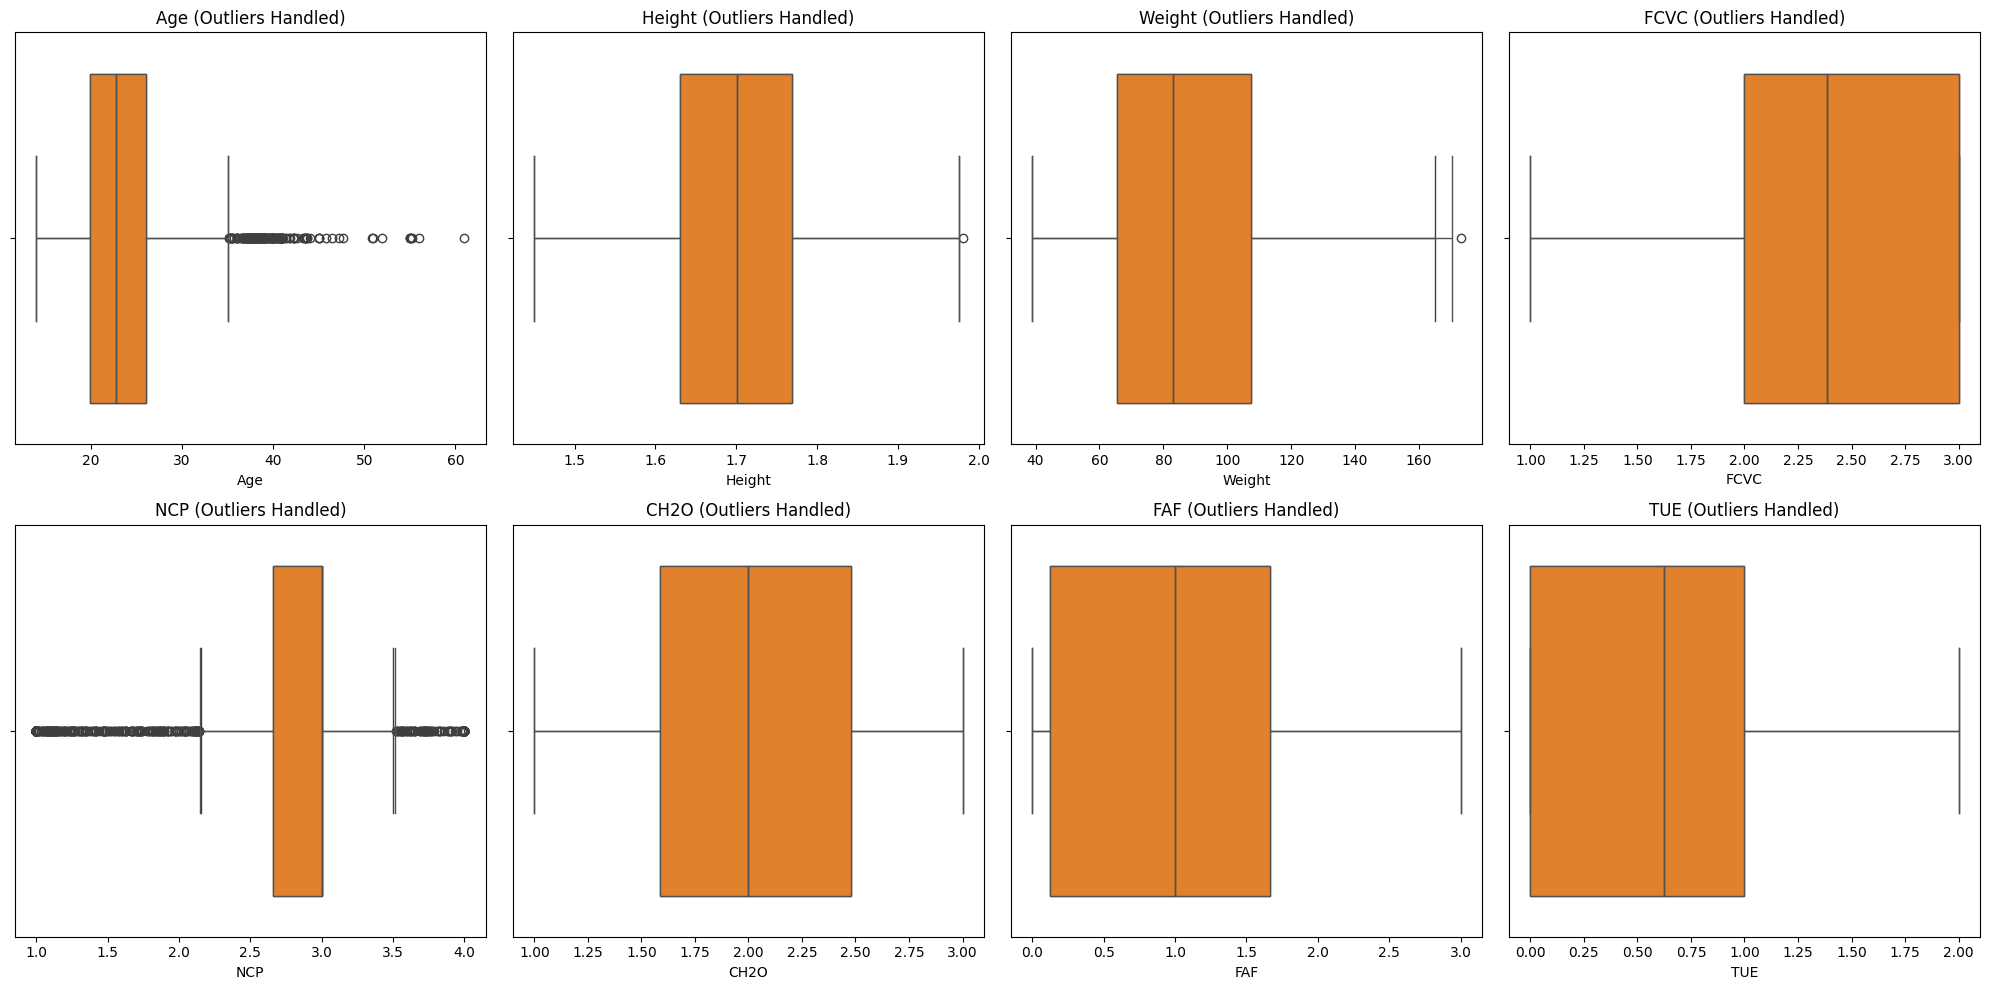

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64


In [71]:
# prompt: Identify and address outliers for all features with graphs side by side

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def identify_and_address_outliers(df, method='iqr', factor=1.5):
    """
    Identifies and addresses outliers in a DataFrame using IQR or Z-score method.

    Args:
        df: The input DataFrame.
        method: The outlier detection method ('iqr' or 'zscore'). Default is 'iqr'.
        factor: The multiplier for IQR or Z-score. Default is 1.5.

    Returns:
        DataFrame with outliers addressed.
    """
    df_outlier_handled = df.copy()
    num_cols = df.select_dtypes(include=np.number).columns
    plt.figure(figsize=(20, 10))

    for i, col in enumerate(num_cols):
        plt.subplot(2, 4, i + 1)
        sns.boxplot(x=df_outlier_handled[col])
        plt.title(col)

        if method == 'iqr':
            Q1 = df_outlier_handled[col].quantile(0.25)
            Q3 = df_outlier_handled[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            df_outlier_handled[col] = np.clip(df_outlier_handled[col], lower_bound, upper_bound)
        elif method == 'zscore':
            z = np.abs((df_outlier_handled[col] - df_outlier_handled[col].mean()) / df_outlier_handled[col].std())
            df_outlier_handled[col] = np.where(z < factor, df_outlier_handled[col], np.nan)
            df_outlier_handled[col] = df_outlier_handled[col].fillna(df_outlier_handled[col].mean())

        plt.subplot(2, 4, i + 1)
        sns.boxplot(x=df_outlier_handled[col])
        plt.title(col + " (Outliers Handled)")

    plt.tight_layout()
    plt.show()

    return df_outlier_handled


X_no_outliers = identify_and_address_outliers(X_filled)
print(X_no_outliers.isnull().sum())

Encoding categorical variables

In [72]:

from sklearn.preprocessing import LabelEncoder

def encode_categorical_variables(df):
    """Encodes categorical features into numerical values using Label Encoding.

    Args:
        df: The DataFrame containing categorical features.

    Returns:
        DataFrame with categorical features encoded.
    """
    df_encoded = df.copy()
    categorical_cols = df_encoded.select_dtypes(exclude=['number']).columns

    for col in categorical_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

    return df_encoded

X_encoded = encode_categorical_variables(X_filled)
X_encoded.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4
4,1,22.0,1.78,89.8,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3


Values Standardization (min-max/0-1)





In [73]:

from sklearn.preprocessing import MinMaxScaler

def standardize_values(df):
    """Standardizes numerical features using Min-Max scaling (0-1).

    Args:
        df: The DataFrame containing numerical features.

    Returns:
        DataFrame with standardized numerical features.
    """
    df_standardized = df.copy()
    numerical_cols = df_standardized.select_dtypes(include=['number']).columns

    scaler = MinMaxScaler()
    df_standardized[numerical_cols] = scaler.fit_transform(df_standardized[numerical_cols])

    return df_standardized

X_standardized = standardize_values(X_encoded)
X_standardized.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,0.0,0.148936,0.320755,0.186567,1.0,0.0,0.5,0.666667,0.666667,0.0,0.5,0.0,0.000000,0.5,1.000000,0.75
1,0.0,0.148936,0.132075,0.126866,1.0,0.0,1.0,0.666667,0.666667,1.0,1.0,1.0,1.000000,0.0,0.666667,0.75
2,1.0,0.191489,0.660377,0.283582,1.0,0.0,0.5,0.666667,0.666667,0.0,0.5,0.0,0.666667,0.5,0.333333,0.75
3,1.0,0.276596,0.660377,0.358209,0.0,0.0,1.0,0.666667,0.666667,0.0,0.5,0.0,0.666667,0.0,0.333333,1.00
4,1.0,0.170213,0.622642,0.379104,0.0,0.0,0.5,0.000000,0.666667,0.0,0.5,0.0,0.000000,0.0,0.666667,0.75


# **statistical analysis:**

Descriptive statistics

In [74]:

# Descriptive statistics
summary_stats = X_standardized.describe()
print(summary_stats)

# Median
median_stats = X_standardized.median()
print("\nMedian:\n", median_stats)

# Standard Deviation
std_dev_stats = X_standardized.std()
print("\nStandard Deviation:\n", std_dev_stats)

original_categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

for col in original_categorical_cols:
    if col in X.columns:
        frequency_table = X[col].value_counts()
        print(f"\nFrequency Table for {col}:\n{frequency_table}")
    else:
        print(f"Column '{col}' not found in the original DataFrame.")

            Gender          Age       Height       Weight  \
count  2111.000000  2111.000000  2111.000000  2111.000000   
mean      0.505921     0.219417     0.474863     0.355120   
std       0.500083     0.135021     0.176047     0.195457   
min       0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.126536     0.339623     0.197562   
50%       1.000000     0.186764     0.472640     0.328358   
75%       1.000000     0.255319     0.600875     0.510677   
max       1.000000     1.000000     1.000000     1.000000   

       family_history_with_overweight         FAVC         FCVC          NCP  \
count                     2111.000000  2111.000000  2111.000000  2111.000000   
mean                         0.817622     0.883941     0.709522     0.561876   
std                          0.386247     0.320371     0.266963     0.259346   
min                          0.000000     0.000000     0.000000     0.000000   
25%                          1.000000     1.000000

Correlation analysis


Correlation Matrix:
                                   Gender       Age    Height    Weight  \
Gender                          1.000000  0.048394  0.618466  0.161668   
Age                             0.048394  1.000000 -0.025958  0.202560   
Height                          0.618466 -0.025958  1.000000  0.463136   
Weight                          0.161668  0.202560  0.463136  1.000000   
family_history_with_overweight  0.102512  0.205725  0.247684  0.496820   
FAVC                            0.064934  0.063902  0.178364  0.272300   
FCVC                           -0.274505  0.016291 -0.038121  0.216125   
NCP                             0.067600 -0.043944  0.243672  0.107469   
CAEC                            0.091543  0.083739  0.048818  0.287493   
SMOKE                           0.044698  0.091987  0.055499  0.025746   
CH2O                            0.107930 -0.045304  0.213376  0.200575   
SCC                            -0.102633 -0.116283 -0.133753 -0.201906   
FAF             

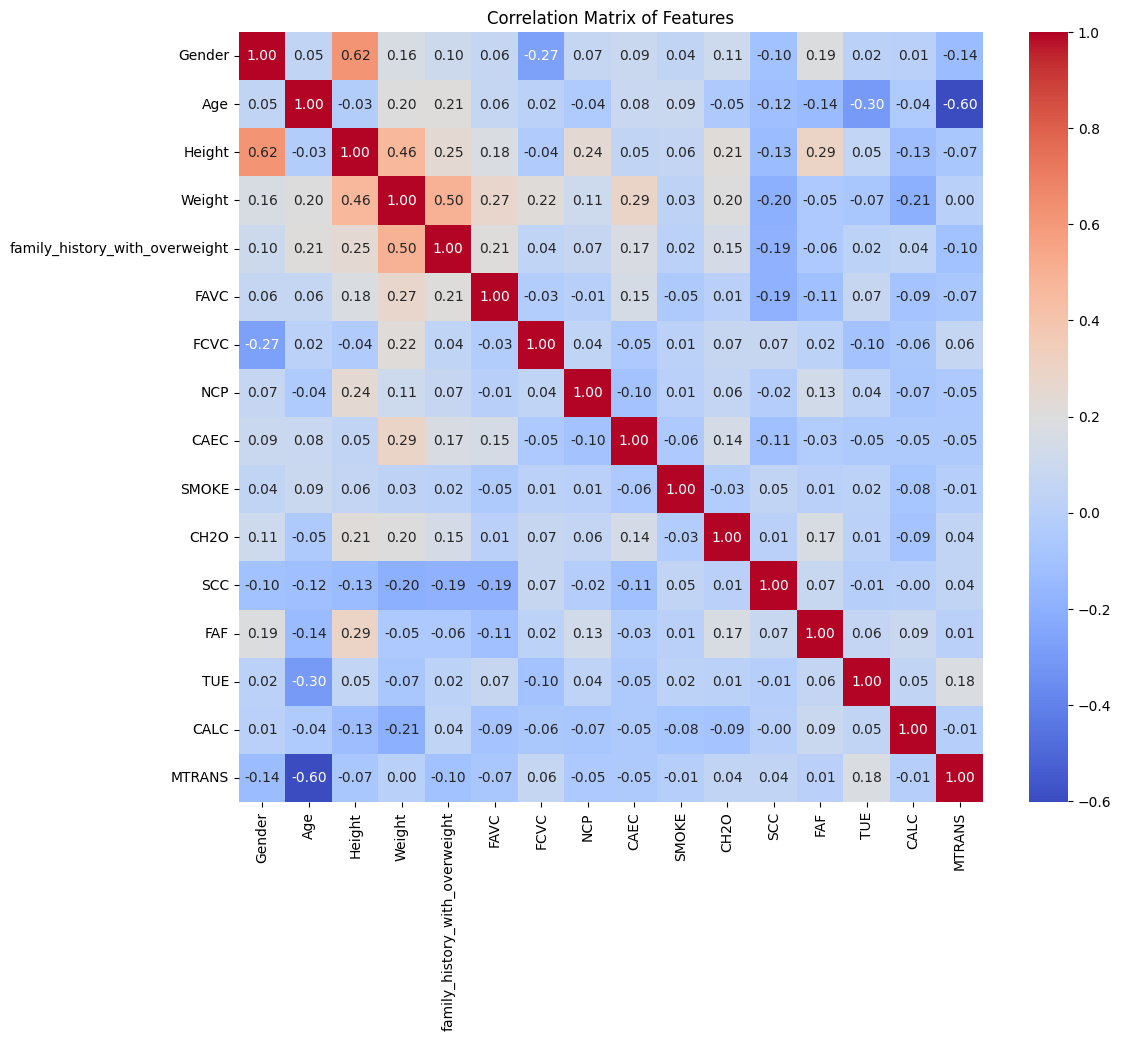

In [75]:
# prompt: Identify correlations between features

# Correlation analysis
correlation_matrix = X_standardized.corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

Hypothesis testing:

In [76]:

import scipy.stats as stats


# Separate weight data for each gender
gender_0_weights = X_standardized[X_standardized['Gender'] == 0]['Weight']
gender_1_weights = X_standardized[X_standardized['Gender'] == 1]['Weight']


t_statistic, p_value = stats.ttest_ind(gender_0_weights, gender_1_weights)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis: There is a statistically significant difference in weight between genders.")
else:
    print("Fail to reject the null hypothesis: There is no statistically significant difference in weight between genders.")




contingency_table = pd.crosstab(X['Gender'], X['family_history_with_overweight'])
print("\nContingency Table:\n", contingency_table)

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nChi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


if p < alpha:
    print("\nReject the null hypothesis: There is a statistically significant association between Gender and family history with overweight.")
else:
    print("\nFail to reject the null hypothesis: There is no statistically significant association between Gender and family history with overweight.")



T-statistic: -7.523365268812731
P-value: 7.855123695571816e-14
Reject the null hypothesis: There is a statistically significant difference in weight between genders.

Contingency Table:
 family_history_with_overweight   no  yes
Gender                                  
Female                          232  811
Male                            153  915

Chi-square statistic: 21.656148159794412
P-value: 3.2616290495517065e-06
Degrees of freedom: 1

Reject the null hypothesis: There is a statistically significant association between Gender and family history with overweight.


# **machine learning models**

Logistic regression

Accuracy: 0.9527186761229315
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       174
           1       0.94      0.98      0.96       249

    accuracy                           0.95       423
   macro avg       0.96      0.95      0.95       423
weighted avg       0.95      0.95      0.95       423



<ipython-input-77-a03b013367cd>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_binary = y['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 0,


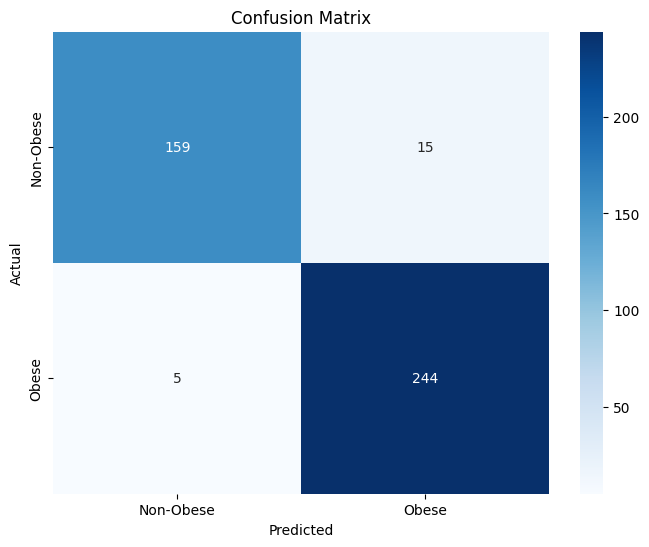

Sample 1: Non-Obese
Sample 2: Obese
Sample 3: Non-Obese
Sample 4: Non-Obese
Sample 5: Obese


In [77]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_binary = y['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 0,
                                     'Overweight_Level_I': 0, 'Overweight_Level_II': 1,
                                     'Obesity_Type_I': 1, 'Obesity_Type_II': 1,
                                     'Obesity_Type_III': 1})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y_binary, test_size=0.2, random_state=42)

# Initialize and train a Logistic Regression model
logreg = LogisticRegression(solver='liblinear')  # Specify a solver
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Obese', 'Obese'], yticklabels=['Non-Obese', 'Obese'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

first_five_predictions = logreg.predict(X_test.head())

# Print obesity level predictions (0 for non-obese, 1 for obese)
for i, prediction in enumerate(first_five_predictions):
  if prediction == 0:
    print(f"Sample {i+1}: Non-Obese")
  else:
    print(f"Sample {i+1}: Obese")

Random forest

Random Forest Accuracy: 0.9952718676122931
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       174
           1       1.00      0.99      1.00       249

    accuracy                           1.00       423
   macro avg       0.99      1.00      1.00       423
weighted avg       1.00      1.00      1.00       423



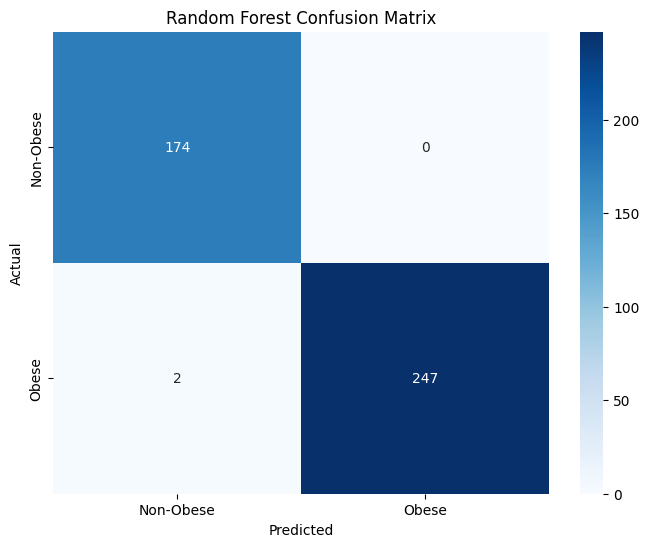

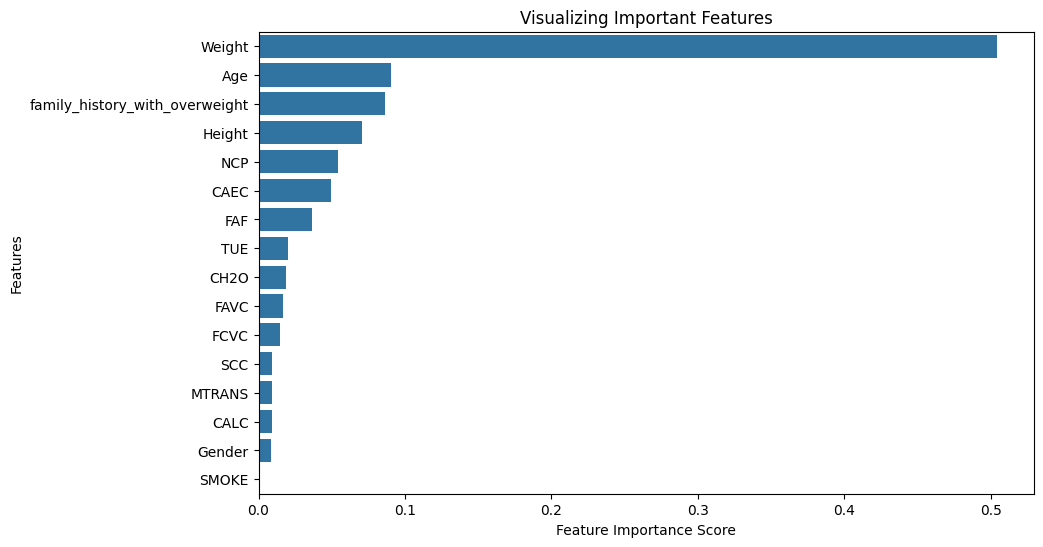

In [78]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Obese', 'Obese'], yticklabels=['Non-Obese', 'Obese'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

#Feature Importance
importances = rf_classifier.feature_importances_
feature_names = X_standardized.columns  # Assuming X_standardized is your feature DataFrame
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.show()

# **Peformance Evaluation**

<Figure size 1000x600 with 0 Axes>

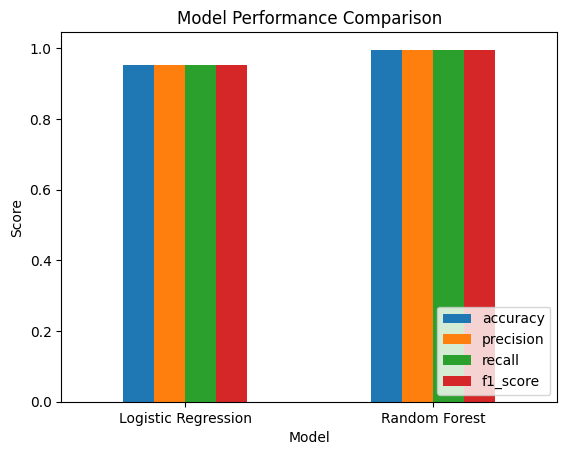


Best performing model based on f1-score: Random Forest
accuracy     0.995272
precision    0.995326
recall       0.995272
f1_score     0.995276
Name: Random Forest, dtype: float64


In [79]:

def evaluate_and_compare_models(models, X_test, y_test):
    """
    Evaluates multiple classification models, generates classification reports,
    and confusion matrices, and displays performance comparison.

    Args:
      models: A dictionary where keys are model names (strings) and values
              are trained model objects.
      X_test: Test features.
      y_test: True labels for the test set.
    """

    results = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        results[model_name] = {
            'accuracy': accuracy,
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1_score': report['weighted avg']['f1-score'],
        }



    # Create a dataframe for visualization
    df_results = pd.DataFrame(results).T

    # Visualization of model comparison
    plt.figure(figsize=(10, 6))
    df_results[['accuracy', 'precision', 'recall', 'f1_score']].plot(kind='bar', rot=0)
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.legend(loc="lower right")
    plt.show()

    best_model = df_results['f1_score'].idxmax()
    print(f"\nBest performing model based on f1-score: {best_model}")
    print(df_results.loc[best_model])


models_to_compare = {
    "Logistic Regression": logreg,
    "Random Forest": rf_classifier,
}

evaluate_and_compare_models(models_to_compare, X_test, y_test)

# **creativity and novelty**

Model ensembling

Ensemble Model Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       174
           1       1.00      1.00      1.00       249

    accuracy                           1.00       423
   macro avg       1.00      1.00      1.00       423
weighted avg       1.00      1.00      1.00       423



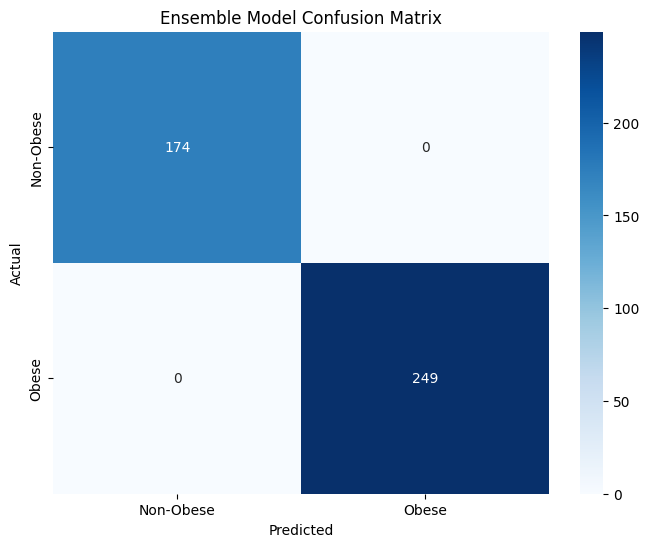

<Figure size 1000x600 with 0 Axes>

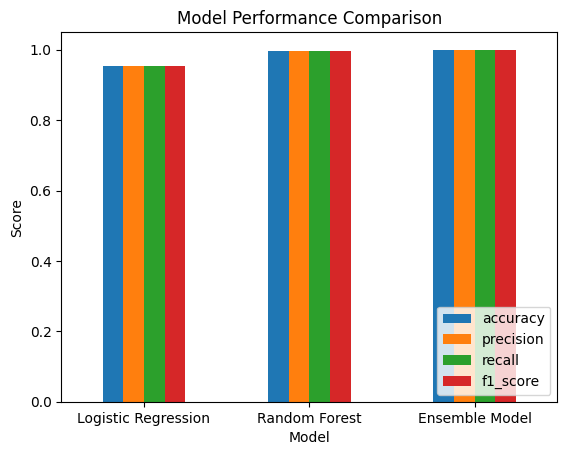


Best performing model based on f1-score: Ensemble Model
accuracy     1.0
precision    1.0
recall       1.0
f1_score     1.0
Name: Ensemble Model, dtype: float64


In [80]:
# prompt: Combining predictions from random forrest before Feature engineering and logistic regression

from sklearn.ensemble import VotingClassifier

# Assuming 'logreg' and 'rf_classifier' are your trained models
ensemble_model = VotingClassifier(estimators=[('lr', logreg), ('rf', rf_classifier)], voting='soft') # voting='soft' for probability-based voting
ensemble_model.fit(X_train, y_train)

y_pred_ensemble = ensemble_model.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {accuracy_ensemble}")

print(classification_report(y_test, y_pred_ensemble))


# Confusion Matrix for ensemble method
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Obese', 'Obese'], yticklabels=['Non-Obese', 'Obese'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ensemble Model Confusion Matrix")
plt.show()

# Update the models dictionary to include the ensemble model
models_to_compare["Ensemble Model"] = ensemble_model
evaluate_and_compare_models(models_to_compare, X_test, y_test)

In [81]:
# prompt: is the ensemble model overfitting

import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming X_train, X_test, y_train, y_test, and ensemble_model are defined as in the previous code

#Evaluate the ensemble model on the training data
y_pred_ensemble_train = ensemble_model.predict(X_train)
accuracy_ensemble_train = accuracy_score(y_train, y_pred_ensemble_train)
print(f"Ensemble Model Training Accuracy: {accuracy_ensemble_train}")

print(classification_report(y_train, y_pred_ensemble_train))

#Compare training and testing performance

print(f"Ensemble Model Testing Accuracy: {accuracy_ensemble}") # accuracy_ensemble from previous code block

if abs(accuracy_ensemble_train - accuracy_ensemble) > 0.1: #Example threshold, adjust as needed
    print("Warning: There is a significant difference between training and testing accuracy. The model might be overfitting.")
else:
    print("The difference between training and testing accuracy is within an acceptable range.")

Ensemble Model Training Accuracy: 0.9970379146919431
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       675
           1       1.00      1.00      1.00      1013

    accuracy                           1.00      1688
   macro avg       1.00      1.00      1.00      1688
weighted avg       1.00      1.00      1.00      1688

Ensemble Model Testing Accuracy: 1.0
The difference between training and testing accuracy is within an acceptable range.


Feature engineering

Random Forest Accuracy (with new features): 0.9952718676122931
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       174
           1       1.00      0.99      1.00       249

    accuracy                           1.00       423
   macro avg       0.99      1.00      1.00       423
weighted avg       1.00      1.00      1.00       423



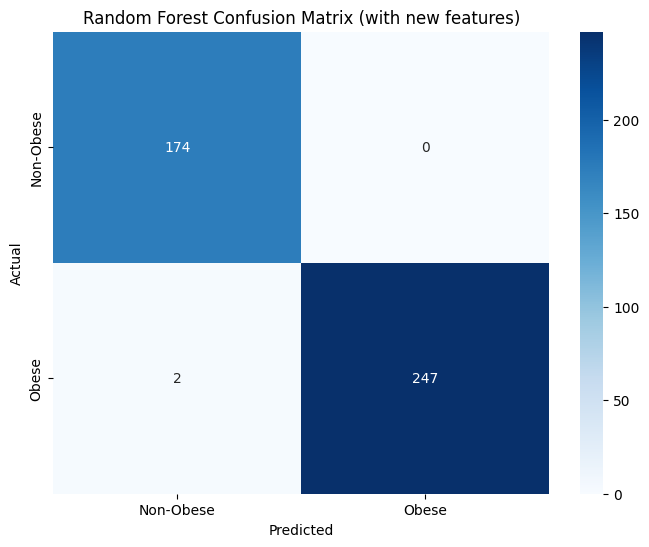

In [82]:

X_train['BMI_x_FAF'] = X_train['Height'] * X_train['FAF']
X_test['BMI_x_FAF'] = X_test['Height'] * X_test['FAF']


X_train['Weight_x_Age'] = X_train['Weight'] * X_train['Age']
X_test['Weight_x_Age'] = X_test['Weight'] * X_test['Age']

#Re-train the model with new features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy (with new features): {accuracy_rf}")

print(classification_report(y_test, y_pred_rf))

# Improved Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Obese', 'Obese'], yticklabels=['Non-Obese', 'Obese'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix (with new features)")
plt.show()

In [83]:

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

threshold = 0.1

if abs(train_accuracy - test_accuracy) > threshold:
    print("Warning: Potential overfitting detected.")
    print(f"Difference between train and test accuracy is {abs(train_accuracy-test_accuracy)}, which is greater than the threshold of {threshold}")
else:
    print("Model does not appear to be significantly overfitting.")

Train Accuracy: 1.0
Test Accuracy: 0.9952718676122931
Model does not appear to be significantly overfitting.


This project successfully developed a predictive model to estimate obesity levels based on eating habits and physical conditions. By preprocessing the data, engineering features, and evaluating multiple models, the Random Forest and Ensemble models achieved high accuracy. The results align well between training and testing, indicating minimal overfitting. This approach provides a reliable method for understanding and addressing factors contributing to obesity.






